In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
from sklearn import preprocessing

In [13]:
doc = pd.read_csv('doc_reports.csv')
facial = pd.read_csv('facial_similarity_reports.csv')

# convert created_at to datetime
doc['created_at'] = pd.to_datetime(doc['created_at'])
facial['created_at'] = pd.to_datetime(facial['created_at'])

#Custom Function for normalizing numeric values between 0.0-1.0
def minmax_norm(df):
    return (df - df.min()) / ( df.max() - df.min())

# 1. Check How the Pass Clear Ratio is Distributed
In order to pass the KYC test, the user must pass two checks. The Document Check and the Face Similarity Check. 
Both checks must be passed for the user to be considered verified. For this reason, it makes sense to examine both checks separately. 
Figure 1 shows that the failure rate for the Document Check is significantly higher. To be precise, the failure rate for the Document Check is four times higher at 24%. 

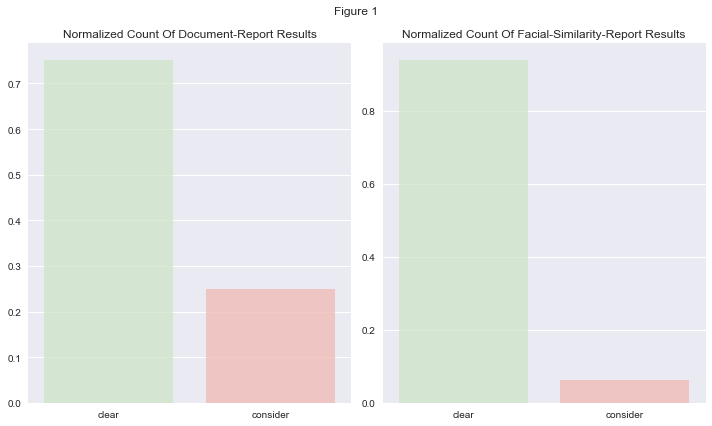

Doc_count: clear       0.750561
consider    0.249439
Name: result, dtype: float64, 
facial_count: clear       0.938108
consider    0.061886
NaN         0.000006
Name: result, dtype: float64


In [14]:
doc_count = doc['result'].value_counts(dropna=False, normalize=True)

custom_palette = ['#CCEBC5','#FBB4AE']
sns.set_palette(custom_palette)

plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.title('Normalized Count Of Document-Report Results')
sns.barplot(x= doc_count.index, y = doc_count.values, alpha=0.8)
plt.tight_layout()

facial_count = facial['result'].value_counts(dropna=False, normalize=True)
plt.subplot(1,2,2)
plt.title('Normalized Count Of Facial-Similarity-Report Results')
sns.barplot(x = facial_count.index, y = facial_count.values, alpha=0.8)
plt.suptitle('Figure 1')


plt.tight_layout()
plt.show()
plt.close()

print(f'Doc_count: {doc_count}, \nfacial_count: {facial_count}')

## 2.Check Overall Verification Success Rate Over Time (weekly)



In order to gain a better overview, the general failure rate is examined in terms of time. Accordingly, two anomalies can be observed in Figure 2.
Firstly, the significant drop at the end of July. Second, a further dramatic drop in the Overall Verification Sucess Rate from the end of September, with a low of around 50% in mid-October. The first anomaly is not investigated further due to the time limitation and is classified as statistically insignificant with a deviation of 15% from the high. The second anomaly is classified as statistically significant due to the immense deviation of 15%-40% and will therefore be examined more closely in the further course. 

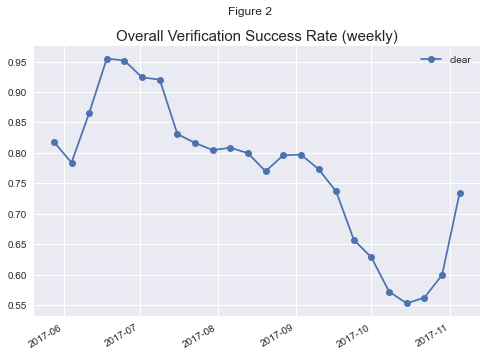

In [15]:
df_merged = pd.merge(doc, facial, how='inner', on = ['user_id', 'attempt_id'])
df_merged['created_at_x'] = pd.to_datetime(df_merged['created_at_x'])

customers_clear = df_merged[(df_merged['result_x'] ==  'clear') & (df_merged['result_y']== 'clear')].groupby(pd.Grouper(key='created_at_x', freq='W'))['result_x'].count().reset_index(name='count')

df_merged_full = df_merged.groupby(pd.Grouper(key='created_at_x', freq='W'))['result_x'].count().reset_index(name='count')

customers_clear['clear_rate'] = customers_clear['count'] / df_merged_full['count']


created_at = customers_clear['created_at_x']
count = customers_clear['clear_rate']

plt.style.use('seaborn')
plt.plot_date(x = created_at, y = count, linestyle='solid', label='clear')
plt.legend()
plt.gcf().autofmt_xdate()
plt.title('Overall Verification Success Rate (weekly)', fontsize=15)
plt.suptitle('Figure 2')

plt.show()


## 2.1 Check Wether The Facial Or Document Check Caused The Dip

This becomes particularly clear when both graphs are shown in one diagram (see Figure 4). From this point on it is clear that the dip is caused by the Document Check. Now the cause must be investigated in the Document Check Report.
As already mentioned, successful verification depends on both checks being passed. If the success rate of the respective checks is visualised over time, it quickly becomes clear that the graph of the Document Report Success Rate is similar to that of the Overall Success Rate, or almost identical (see Figure 3). 


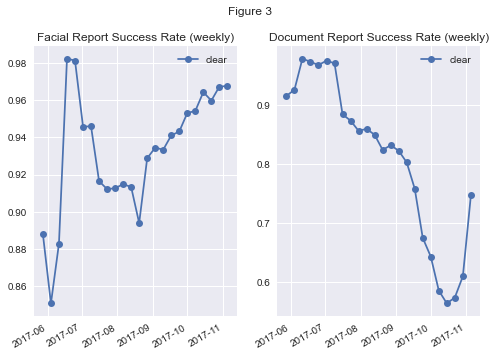

In [16]:
#########
#Facial Report Clear Rate
#########
facial_result = facial[facial['result'] == 'clear']
facial_full = facial.groupby(pd.Grouper(key='created_at', freq='W'))['result'].count().reset_index(name='count')
temp = facial_result.groupby(pd.Grouper(key='created_at', freq='W'))['result'].count().reset_index(name='count')
temp.sort_values(by=['created_at'], inplace=True)

temp['clear_rate'] = temp['count'] / facial_full['count']
created_at = temp['created_at']
count = temp['clear_rate']

plt.subplot(1,2,1)
plt.style.use('seaborn')
plt.plot_date(created_at, count, linestyle='solid', label='clear')
plt.legend()
plt.gcf().autofmt_xdate()
plt.title('Facial Report Success Rate (weekly)')

#########
#Document Report Clear Rate
#########

doc_result = doc[doc['result'] == 'clear']
doc_full = doc.groupby(pd.Grouper(key='created_at', freq='W'))['result'].count().reset_index(name='count')
temp = doc_result.groupby(pd.Grouper(key='created_at', freq='W'))['result'].count().reset_index(name='count')
temp.sort_values(by=['created_at'], inplace=True)

temp['clear_rate'] = temp['count'] / doc_full['count']
created_at = temp['created_at']
count = temp['clear_rate']

plt.subplot(1,2,2)
plt.style.use('seaborn')
plt.plot_date(created_at, count, linestyle='solid', label='clear')
plt.legend()
plt.gcf().autofmt_xdate()
plt.title('Document Report Success Rate (weekly)')
plt.suptitle('Figure 3')

plt.show()

Text(0.5, 0.98, 'Figure 4')

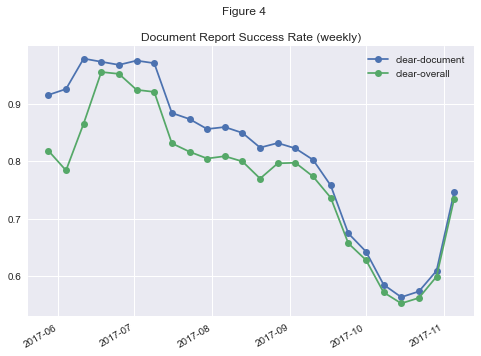

In [17]:
doc_result = doc[doc['result'] == 'clear']
doc_full = doc.groupby(pd.Grouper(key='created_at', freq='W'))['result'].count().reset_index(name='count')
temp = doc_result.groupby(pd.Grouper(key='created_at', freq='W'))['result'].count().reset_index(name='count')
temp.sort_values(by=['created_at'], inplace=True)

temp['clear_rate'] = temp['count'] / doc_full['count']
created_at = temp['created_at']
count = temp['clear_rate']

plt.style.use('seaborn')
plt.plot_date(created_at, count, linestyle='solid', label='clear-document')

df_merged = pd.merge(doc, facial, how='inner', on = ['user_id', 'attempt_id'])
df_merged['created_at_x'] = pd.to_datetime(df_merged['created_at_x'])

customers_clear = df_merged[(df_merged['result_x'] ==  'clear') & (df_merged['result_y']== 'clear')].groupby(pd.Grouper(key='created_at_x', freq='W'))['result_x'].count().reset_index(name='count')

df_merged_full = df_merged.groupby(pd.Grouper(key='created_at_x', freq='W'))['result_x'].count().reset_index(name='count')

customers_clear['clear_rate'] = customers_clear['count'] / df_merged_full['count']

created_at = customers_clear['created_at_x']
count = customers_clear['clear_rate']

plt.plot_date(created_at, count, linestyle='solid', label='clear-overall')

plt.legend()
plt.gcf().autofmt_xdate()
plt.title('Document Report Success Rate (weekly)')
plt.suptitle('Figure 4')

## 3. The document report result can be divided into three sub-results: Rejected, Suspected, Caution 

A "fail" of the Document Check is divided into four sub-results: Rejected, Suspected, Caution. Accordingly, the equal share of the respective sub-results is examined. 
The pie chart (see Figure 5) shows that the results "Suspected" and "Rejected" account for approximately 96% of the failed document checks. With a marginal share of 4.4%, the sub-result "Suspected" can be held responsible for the failed document checks. For this reason, the cause in "Suspected" is not pursued further, but in "Caution" and "Rejected". 


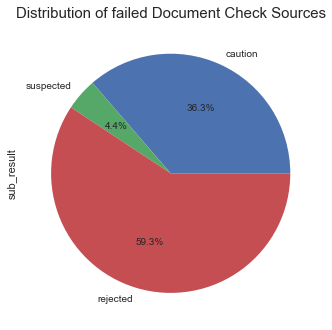

In [18]:
plt.tight_layout()
plt.suptitle('Figure 5')
plt.style.use('seaborn')
plt.title('Distribution of failed Document Check Sources', fontsize=15)
pie_chart = doc[doc['sub_result'] != 'clear'].groupby(pd.Grouper(key='sub_result'))['sub_result'].count().plot(kind='pie', y='sub_results',autopct='%1.1f%%')

In [19]:
document_marker = [
'visual_authenticity_result',
'image_integrity_result',
'face_detection_result', 
'supported_document_result',
'conclusive_document_quality_result',
'colour_picture_result',
'data_validation_result',
'data_consistency_result',
'data_comparison_result',
'police_record_result',
'compromised_document_result']

The sub-results are determined by 12 indicators, which can be seen in Figure 6-8. 

In order to determine the cause of the respective sub-results, the 'behaviour' of the indicators per sub-result is compared with each other. The 'behaviour' of the indicators of the sub-result 'Clear' is considered the baseline. Deviations from its pattern are identified as the cause. In the following, the 'behaviour' of the indicators of the two sub-results 'Rejected' and 'Caution' is examined. 

1. Rejected (see Figure 7):
9 indicators are completely missing or their results are not existent. 
All Rejected incidents have an Image Integrity Check, of which 100% have failed. The Image Quality Result provides information on this. Here you can see that approx. 99% were classified as unidentified. In comparison, with the sub-result clear, the unidentified rate is 0%. Since the image quality result determines the image integrity result, the image quality can be identified as the cause. 
Taking into account that all other indicators are missing and the poor image quality results, this may be due to a technical problem on the part of the Revolut app or the Veritas API. 

Final thoughts and assumptions: Regarding the poor image quality results, it could be that the Veritas API has introduced a new file format as a standard for data transmission. 

 2. Caution (see Figure 8):
The 'behaviour' of the Caution indicators shows two significant deviations. First, in the Image Integrity Result. Second, in the Conclusive Document Result. Obviously, the poor Image Integrity Results are caused by the Conclusive Document Results. 

Concluding thoughts and assumptions: The type of document causing the poor results should be further investigated. It is also possible that these users simply tried to register with the wrong documents.


/Users/hakkarsama/.pyenv/versions/masterarbeit/lib/python3.8/site-packages/pandas/core/frame.py:4459: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


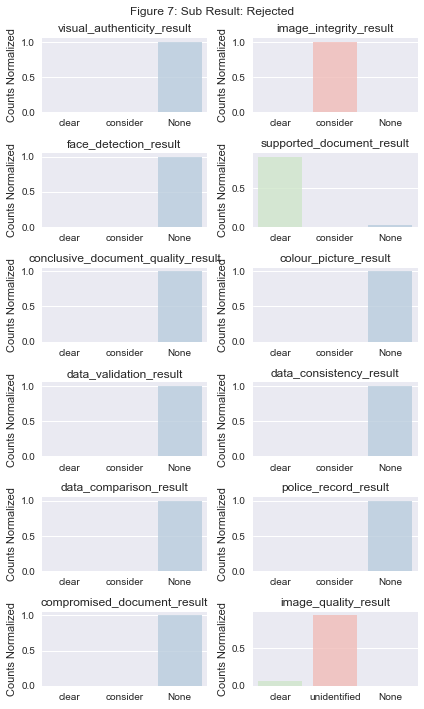

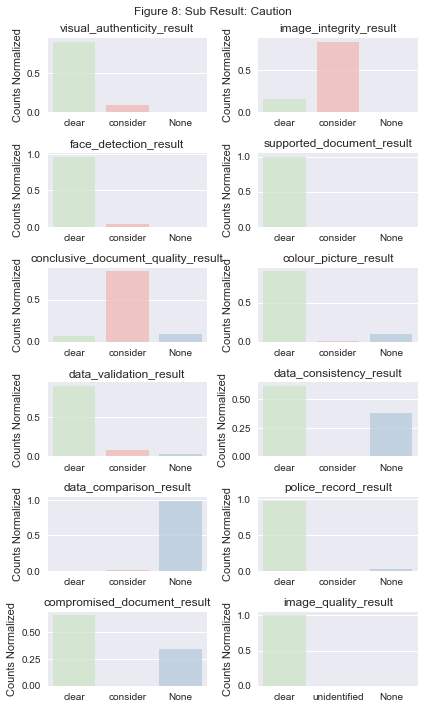

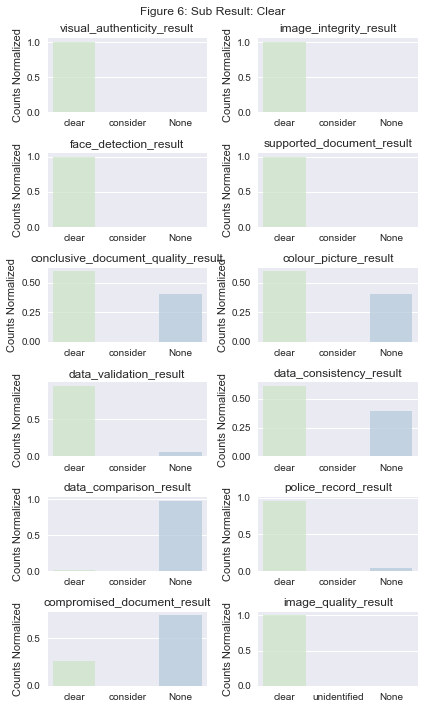

In [20]:
df1 = doc[doc['sub_result']=='rejected']
df2 = doc[doc['sub_result']=='caution']
df3 = doc[doc['sub_result']=='clear']

df1.fillna('None', inplace=True)
df2.fillna('None', inplace=True)
df3.fillna('None', inplace=True)

category_order = ['clear', 'consider', 'None']
custom_palette = ['#CCEBC5','#FBB4AE', '#B3CDE3']
category_order_visual_integrity = ['clear', 'unidentified', 'None']


temp = 1
plt.figure(figsize=(6,10))
for marker in document_marker:
    plt.subplot(6,2,temp)
    temp = temp + 1
    a = df1[marker].value_counts(normalize=True, dropna=False)
    sns.set_palette(custom_palette)
    sns.barplot(x = a.index, y = a.values, alpha=0.8, order=category_order)
    plt.title(marker)
    plt.ylabel('Counts Normalized')

plt.subplot(6,2,12)
a = df1['image_quality_result'].value_counts(normalize=True, dropna=False)
sns.barplot(x = a.index, y = a.values, alpha=0.8, order=category_order_visual_integrity)
sns.set_palette(custom_palette)
plt.title('image_quality_result')
plt.ylabel('Counts Normalized')

plt.suptitle('Figure 7: Sub Result: Rejected', fontsize=12)
plt.tight_layout()
plt.show()

#######
plt.figure(figsize=(6,10))
temp = 1
for marker in document_marker:
    plt.subplot(6,2,temp)
    temp = temp + 1
    a = df2[marker].value_counts(normalize=True, dropna=False)
    sns.barplot(x = a.index, y = a.values, alpha=0.8, order=category_order)
    plt.title(marker)
    plt.ylabel('Counts Normalized')

plt.subplot(6,2,temp)
a = df2['image_quality_result'].value_counts(normalize=True, dropna=False)
sns.barplot(x= a.index, y= a.values, alpha=0.8, order=category_order_visual_integrity)
sns.set_palette(custom_palette)
plt.title('image_quality_result')
plt.ylabel('Counts Normalized')

plt.suptitle('Figure 8: Sub Result: Caution', fontsize=12)
plt.tight_layout()
plt.show()

#########
plt.figure(figsize=(6,10))
temp = 1
for marker in document_marker:
    plt.subplot(6,2,temp)
    temp = temp + 1
    a = df3[marker].value_counts(normalize=True, dropna=False)
    sns.barplot(x = a.index, y = a.values,alpha=0.8, order=category_order)
    plt.title(marker)
    plt.ylabel('Counts Normalized')

plt.subplot(6,2,temp)
a = df3['image_quality_result'].value_counts(normalize=True, dropna=False)
sns.barplot(x = a.index, y = a.values, alpha=0.8, order=category_order_visual_integrity)
sns.set_palette(custom_palette)
plt.title('image_quality_result')
plt.ylabel('Counts Normalized')

plt.suptitle('Figure 6: Sub Result: Clear', fontsize=12)
plt.tight_layout()
plt.show()
plt.close()

## 4. Solutions

Possible solutions:

Possible solutions by changing external factors: 
- Arrange a meeting with the data engineering team and Veritas customer support. Ask specifically whether and to what extent procedural changes were made to the service during the August period.  
- Only if it is really due to a technical error and Veritas cannot provide a solution or cause for the problem: Change KYC provider.  After 5 minutes of googling, I discovered Onfidio. Immediately, I noticed that the documentation was much cleaner and easier to understand. Other providers should be considered:

Jumio Identity Verification.
LastPass.
Trulioo.
RSA SecurID® Access.
LexisNexis LexID.
IDnow.
Veriff.
Pipl.

Possible solutions by changing internal factors:
- Set up task force with data engineering team. 
- Carry out detailed analysis of the data.
